In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.feature_selection import chi2
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pickle

In [2]:
# loading the data

data = pd.read_csv('reviews_clean2.csv', sep=';', encoding='utf-8', index_col='Unnamed: 0')

data.head()

,review,title,tag,rating,cleaned_review
0,"\n\n\n\n\n\n Cringe ""comedy"" in...",Amagi Brilliant Park,Not Recommended,2,Cringe comedy in a nutshell except there's not...
1,\n\n\n\n\n\n So this is the thi...,Higeki no Genkyou to Naru Saikyou Gedou Last B...,Mixed Feelings,5,So this is the thing about this anime. some sp...
2,\n\n\n\n\n\n The show is depres...,Sousou no Frieren,Recommended,9,The show is depressing as fuck. But good. As f...
3,"\n\n\n\n\n\n Ugly CGI, bland vi...",Kimetsu no Yaiba,Not Recommended,3,"Ugly CGI, bland villains, bland one-dimensiona..."
4,\n\n\n\n\n\n Boring. Cliche. La...,Ousama Ranking,Not Recommended,2,Boring. Cliche. Lame. Ousama Ranking is extrem...


### 1. Creating embeddings & selecting features

Feature selection with CHI² test helps determine which features are most dependent to the value we are trying to predict. Wordclouds below show the top scored features after simple Tfidf vectorization and after applying CHI² test. \
Source article: https://medium.com/@kenanekici/your-tfidf-features-are-garbage-heres-how-to-fix-it-ca548883d8a0

In [4]:
X = data.cleaned_review
y = data.rating

In [4]:
def generate_tfidf_wordcloud(tfidf_dict):
    '''generates a wordcloud
    from a {feature: score} dict
    '''
    wordcloud = WordCloud(max_font_size=40, background_color="white", width=1000, height=500)
    wordcloud.generate_from_frequencies(frequencies=tfidf_dict)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Top features with no chi-squared test


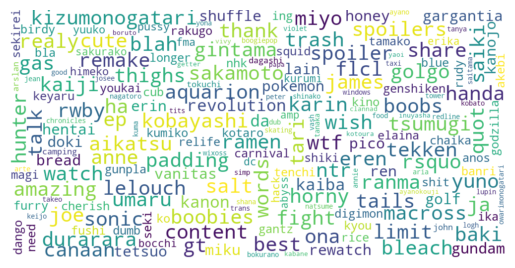

Top features with chi-squared test


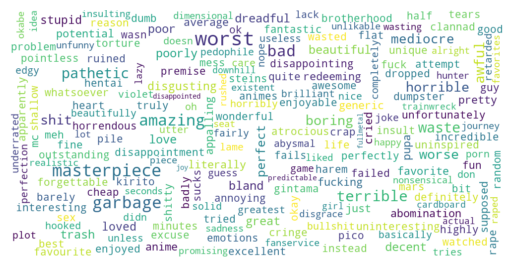

In [5]:
# generating wordclouds from 500 top tfidf features with and without chi-squared test

n_features = 500

tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=10000)
X_ = tfidf_vectorizer.fit_transform(X)
tfidf_features = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = X_.max(0).toarray()[0]
tfidf_top_indices = np.argsort(tfidf_scores)[-n_features:][::-1]
tfidf_top_features = {}
for i in tfidf_top_indices:
    feature = tfidf_features[i]
    score = tfidf_scores[i]
    tfidf_top_features[feature] = score

chi2score = chi2(X_,y)[0]
wscores = zip(tfidf_vectorizer.get_feature_names_out(), chi2score)
wchi2 = sorted(wscores,key=lambda x:x[1])
topchi2 = wchi2[-n_features:]
topchi2_dict = {key: value for key, value in topchi2}

print('Top features with no chi-squared test')
generate_tfidf_wordcloud(tfidf_top_features)
print('Top features with chi-squared test')
generate_tfidf_wordcloud(topchi2_dict)

The features selected with CHI² test are significantly more relevant to the rating prediction task. \
\
The next challenge is to select the optimal ngram range for the feature extraction and the number of features. Below are the lists of parameters that I'll pass to TfidfVectorizer, and then store the result matrices to later evaluate the regression models on all of them to determine how the results are affected by the selection of features.

In [5]:
num_features = [2000, 5000, 10000]
ngram_ranges = [(1,1), (1,2), (1,3)]

In [ ]:
# creating and storing matrices with the specified ngram ranges and feature numbers along with their parameters and features

tfidf_matrices = []
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

for ngram_range in ngram_ranges:
    temp_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=ngram_range, max_features=10000)
    X_ = temp_vectorizer.fit_transform(X_train)
    chi2score = chi2(X_,y_train)[0]
    wscores = zip(temp_vectorizer.get_feature_names_out(), chi2score)
    wchi2 = sorted(wscores,key=lambda x:x[1])
    for num in num_features:
        topchi2 = wchi2[-num:]
        features = [t for t, ch in topchi2]
        vectorizer_chi = TfidfVectorizer(stop_words='english', vocabulary=features, lowercase=True)
        train_matrix = vectorizer_chi.fit_transform(X_train)
        test_matrix = vectorizer_chi.transform(X_test)
        tfidf_wparams = (ngram_range, num, train_matrix, test_matrix, features)
        tfidf_matrices.append(tfidf_wparams)

In [5]:
# pickling the matrices

with open('tfidf_matrices.pkl', 'wb') as f: 
    pickle.dump(tfidf_matrices, f)

# with open('tfidf_matrices.pkl', 'rb') as f:
#     tfidf_matrices = pickle.load(f)

### 2. SGDRegressor with RandomizedSearchCV

SGDRegressor offers a robust framework that can handle large datasets and high-dimensional feature spaces efficiently. Through experimentation with various regression models, including Linear Regression and Ridge Regression, I found that SGDRegressor yielded equivalent results. This outcome underscores the adaptability of SGDRegressor in replicating the behavior of other regression models while offering additional advantages such as scalability to large datasets and flexibility in hyperparameter tuning.

Source: https://towardsdatascience.com/sgdregressor-with-scikit-learn-untaught-lessons-you-need-to-know-cf2430439689

RandomizedSearchCV efficiently explores a wide range of hyperparameter combinations within a specified search space. This is particularly useful when dealing with a high-dimensional parameter space, as it randomly samples a subset of hyperparameter combinations for evaluation. Compared to GridSearchCV, which exhaustively searches through all possible combinations, RandomizedSearchCV can often yield similar or even better results in less time.

In [6]:
sgd_model_results = {}
sgd_model_id = 1

for matrix in tfidf_matrices:
    param_dist = {
        'loss': ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        'penalty': ['l2', 'l1', 'elasticnet', None],
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 4.0, 10.0],
        'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
        }   
    random_search = RandomizedSearchCV(
        estimator=SGDRegressor(),
        param_distributions=param_dist,
        n_iter=20,
        cv=5, 
        scoring='neg_mean_absolute_error', 
        random_state=42,
        n_jobs=-1
            )
    
    random_search.fit(matrix[2], y_train)

    train_predictions = random_search.best_estimator_.predict(matrix[2])
    train_rmse = mean_squared_error(y_train, train_predictions, squared=False)

    test_predictions = random_search.best_estimator_.predict(matrix[3])
    test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

    model_result = (matrix[0], matrix[1], train_rmse, test_rmse, random_search.best_params_)
    model_name = 'model'+str(sgd_model_id)
    sgd_model_results[model_name] = model_result
    sgd_model_id+=1

pd.options.display.float_format = '{:,.4f}'.format
columns=['ngram_range', 'num_features', 'train_rmse', 'test_rmse', 'best_params']
sgd_df = pd.DataFrame.from_dict(sgd_model_results, orient='index', columns=columns)
exploded_params = sgd_df['best_params'].apply(pd.Series) # exploding parameters for clarity
sgd_df = pd.concat([sgd_df, exploded_params], axis=1)
sgd_df

,ngram_range,num_features,train_rmse,test_rmse,best_params,penalty,loss,learning_rate,alpha
model1,"(1, 1)",2000,1.5219,1.5460,"{'penalty': None, 'loss': 'squared_error', 'le...",None,squared_error,constant,0.0100
model2,"(1, 1)",5000,1.4837,1.5305,"{'penalty': None, 'loss': 'squared_error', 'le...",None,squared_error,constant,0.1000
model3,"(1, 1)",10000,1.4562,1.5318,"{'penalty': None, 'loss': 'squared_error', 'le...",None,squared_error,constant,0.1000
model4,"(1, 2)",2000,1.5421,1.5596,"{'penalty': None, 'loss': 'squared_error', 'le...",None,squared_error,constant,0.0100
model5,"(1, 2)",5000,1.5068,1.5387,"{'penalty': None, 'loss': 'squared_error', 'le...",None,squared_error,constant,0.0100
model6,"(1, 2)",10000,1.4814,1.5360,"{'penalty': None, 'loss': 'squared_error', 'le...",None,squared_error,constant,0.0100
model7,"(1, 3)",2000,1.5450,1.5622,"{'penalty': None, 'loss': 'squared_error', 'le...",None,squared_error,constant,0.1000
model8,"(1, 3)",5000,1.5071,1.5389,"{'penalty': None, 'loss': 'squared_error', 'le...",None,squared_error,constant,0.0100
model9,"(1, 3)",10000,1.4819,1.5365,"{'penalty': None, 'loss': 'squared_error', 'le...",None,squared_error,constant,0.1000


### 3. Evaluation & Visualizations

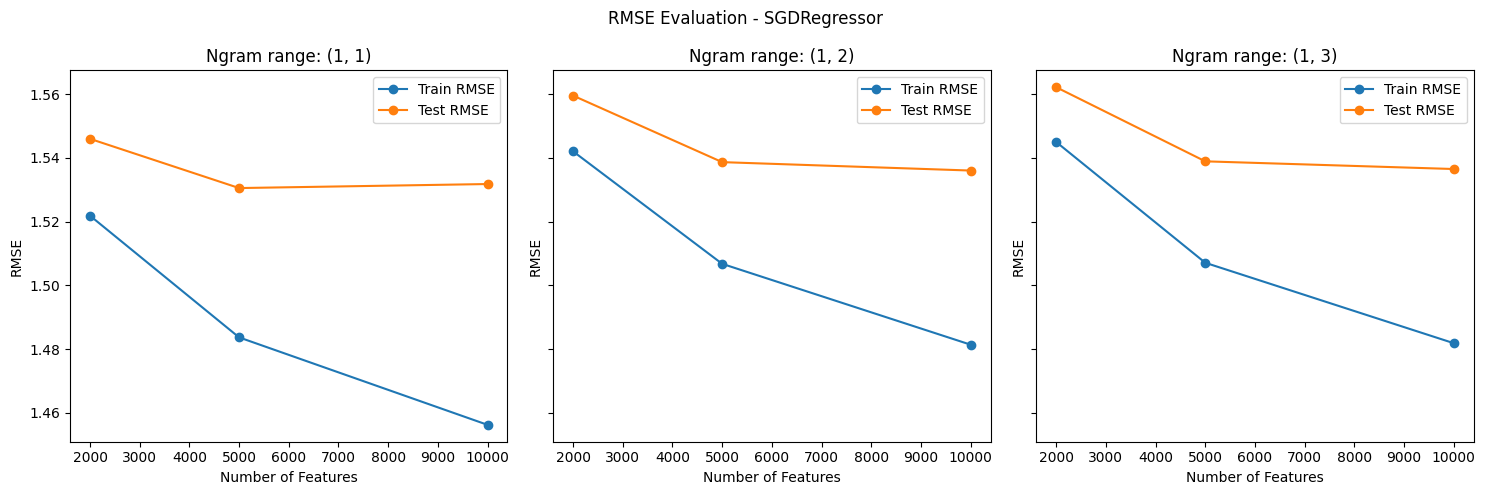

In [7]:
# visualizing the RMSE scores for models trained on matrices with various ngram ranges and feature numbers

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, ngram_range in enumerate(sgd_df['ngram_range'].unique()):
    ngram_df = sgd_df[sgd_df['ngram_range'] == ngram_range]

    axs[i].plot(ngram_df['num_features'], ngram_df['train_rmse'], marker='o', label='Train RMSE')
    axs[i].plot(ngram_df['num_features'], ngram_df['test_rmse'], marker='o', label='Test RMSE')
    
    axs[i].set_title(f'Ngram range: {ngram_range}')
    axs[i].set_xlabel('Number of Features')
    axs[i].set_ylabel('RMSE')
    
    axs[i].legend()

plt.suptitle('RMSE Evaluation - SGDRegressor')
plt.tight_layout()
plt.show()

Bigger difference between train and test metrics is a sign of model overfitting. From the plots, it appears that the smallest number of features is the best fit for the models, but at the same time, the matrices with 5000 features and (1,2), (1,3) ngrams yield lower RMSE while still maintaining a decent fit.
\
As the optimal option, I will pick the (1,2) ngram x 5000 features matrix to evaluate on the best performing model.

In [8]:
sgd_ngram_range = (1,2)
sgd_num_features = 5000

In [9]:
best_ngram, best_num_features, best_params = sgd_df.loc[
                                           (sgd_df['ngram_range'] == sgd_ngram_range) & (sgd_df['num_features'] == sgd_num_features), 
                                           ['ngram_range', 'num_features', 'best_params']
                                           ].iloc[0]

for matrix in tfidf_matrices:
    if ((matrix[0] == best_ngram) and (matrix[1] == best_num_features)):
        best_matrix = matrix[2]
        best_features = matrix[3]

X_train, X_test, y_train, y_test = train_test_split(best_matrix, y, train_size=0.75, random_state=42)     
best_sgd_model = SGDRegressor()
best_sgd_model.set_params(**best_params)
best_sgd_model.fit(X_train, y_train)

sgd_y_pred_train = best_sgd_model.predict(X_train)
sgd_y_pred_test = best_sgd_model.predict(X_test)

sgd_r2_train = best_sgd_model.score(X_train, y_train)
sgd_rmse_train = mean_squared_error(y_train, sgd_y_pred_train, squared=False)
sgd_r2_test = best_sgd_model.score(X_test, y_test)
sgd_rmse_test = mean_squared_error(y_test, sgd_y_pred_test, squared=False)
print('Best SGDRegressor model scores:')
print('Train R^2 score: %.2f' % sgd_r2_train)
print('Train RMSE: %.2f' % sgd_rmse_train)
print('Test R^2 score: %.2f' % sgd_r2_test)
print('Test RMSE: %.2f' % sgd_rmse_test)

Best SGDRegressor model scores:
Train R^2 score: 0.60
Train RMSE: 1.51
Test R^2 score: 0.58
Test RMSE: 1.54


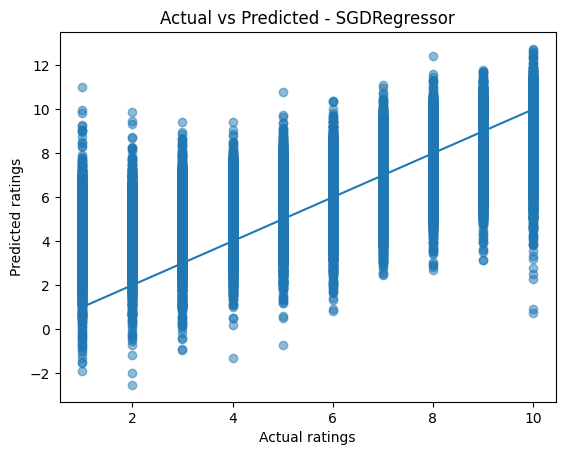

In [10]:
# plotting Actual vs. Predicted test results

plt.scatter(y_test, sgd_y_pred_test, alpha=0.5)
plt.title('Actual vs Predicted - SGDRegressor')
plt.xlabel('Actual ratings')
plt.ylabel('Predicted ratings')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])

plt.show()

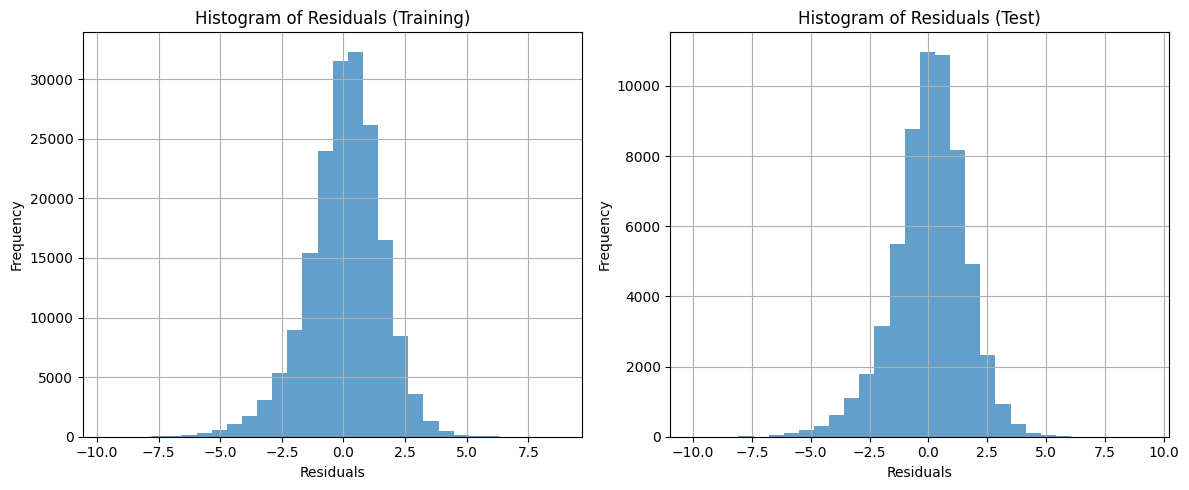

In [11]:
# plotting the histogram of residuals for train and test

residuals_train = y_train - sgd_y_pred_train
residuals_test = y_test - sgd_y_pred_test

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(residuals_train, bins=30, alpha=0.7)
plt.title('Histogram of Residuals (Training)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(residuals_test, bins=30, alpha=0.7)
plt.title('Histogram of Residuals (Test)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

A slightly negatively skewed distribution of residuals suggests that the prediction model tends to slightly overestimate the ratings more often than it underestimates them. 

### 4. Making predictions on new reviews

In [12]:
new_examples = [
    'I just LOVE this anime, it is so much different than yaoi, coming to age or anything else. It is SO emotionally charged and sensitive, and it causes you sympathy. The movie was good, but not as good as the anime. hence, we need a season 2 and know what is to happen next. Thank you, because this show made my year and it is so thoroughly done its outstanding. Thank you!',
    'This story catches those small, everyday actions of being human. Those awkward silences, fluttery feelings, and pauses that are so hard to put into words are beautifully animated here. The characters are so easy to relate to and they interact so easily. This show is so mellow and restful but it covers hardships and trauma with grace that is rarely seen. I can\'t recommend this story enough. It made me laugh and fan girl and think - I love this story.',
    'Although I\'m not really a big fan of the \"incest\" genre, I felt like watching it just because I wanted to see something at least different and that it\'ll change my mind. Boy was I in hot water.....it was the worst anime I\'ve ever seen in the 2018 range. Not because of what\'s its about but what it offered. It offered boredom and irritating characters who made me cringe the entire time. Thank God I only watched episode one and didnt waste watching the other 9 eps like seriously!',
    'This ten part anime series in centred on Yuu Nagami, a high school student who hopes to become a light novel author. Things don\'t quite go according to plan when a competition he enters is won by Suzuka, his younger sister writing under a nom de plume. She doesn\'t want the attention that goes with winning so encourages Yuu take the credit. The story in question is of the \'little sister\' genre and it soon becomes clear that Suzuka has feelings for her brother! She isn\'t the only one; just about every female character what to be treated as the loved younger sister! \'Little Sisters\' seem to be a popular trend in recent anime; usually they at least feature step-sisters or it is clear that their closeness isn\'t sexual but not here. It is posed as researching situations for her ongoing writings but it is clear they are in taboo territory and they know it. The plot provides plenty of excuses for fan-service; involving both Suzuka and the other female characters. On the plus side it is quite funny at times. The animation isn\'t that great, certainly when compared to most current series I\'ve watched. Overall I\'m not sure I\'d recommend this to anybody who isn\'t connoisseur of trashy anime.',
    'The worst thing I have ever seen and I would never recommend it to anyone, not to my worst enemy'
]

In [19]:
best_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, vocabulary=best_features)
best_vectorizer.fit(X)
vectorized_text = best_vectorizer.transform(new_examples)

predictions = best_sgd_model.predict(vectorized_text)
clipped_labels = np.clip(predictions, 1, 10)   # rating cannot be lower than 1 and higher than 10
predicted_labels = [round(label) for label in clipped_labels]    # rounding the values as the rating can only be an integer

for review, label in zip(new_examples, predicted_labels):
    print('Review:', review, '\n')
    print('Predicted rating:', label, '\n')

Review: I just LOVE this anime, it is so much different than yaoi, coming to age or anything else. It is SO emotionally charged and sensitive, and it causes you sympathy. The movie was good, but not as good as the anime. hence, we need a season 2 and know what is to happen next. Thank you, because this show made my year and it is so thoroughly done its outstanding. Thank you! 

Predicted rating: 9 

Review: This story catches those small, everyday actions of being human. Those awkward silences, fluttery feelings, and pauses that are so hard to put into words are beautifully animated here. The characters are so easy to relate to and they interact so easily. This show is so mellow and restful but it covers hardships and trauma with grace that is rarely seen. I can't recommend this story enough. It made me laugh and fan girl and think - I love this story. 

Predicted rating: 9 

Review: Although I'm not really a big fan of the "incest" genre, I felt like watching it just because I wanted 